<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/pytorch_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.utils import make_grid
from torchsummary import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.4
seaborn: 0.11.0
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Data

In [3]:
image_size = 32
batch_size = 128

transform = Compose([Resize(image_size), ToTensor()])

ds_train = dset.FashionMNIST("data", train=True, download=True, transform=transform)
ds_test = dset.FashionMNIST("data", train=False, download=True, transform=transform)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

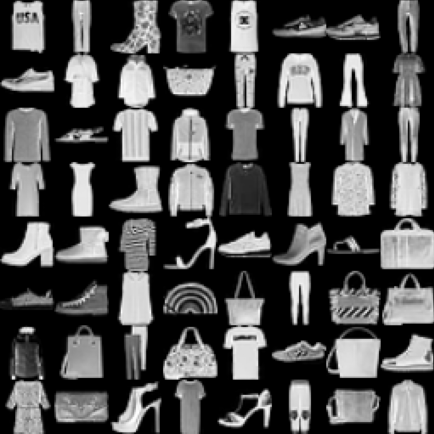

In [4]:
images, _ = next(iter(train_loader))

fig, ax = plt.subplots(figsize=(4,4))

img = make_grid(images[:64], nrow=8, padding=0).permute(1,2,0).numpy()

ax.imshow(img)
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

## Model

In [16]:
def weights_init(m, mean=0.0, std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean, std)
        nn.init.zeros_(m.bias)

class Encoder(nn.Module):
    def __init__(self, cin=1, cout=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, cout)
        self.fc_logvar = nn.Linear(128 * 4 * 4, cout)
        
    def forward(self, x):
        x = self.net(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, cin=128, cout=1):
        super().__init__()
        self.cin = cin
        self.fc1 = nn.Linear(cin, cin * 4 * 4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            
            nn.ConvTranspose2d(32, cout, 4, 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, self.cin, 4, 4)
        x = F.leaky_relu(x, 0.2)
        return self.net(x)
    
class VAE(nn.Module):
    def __init__(self, nz=128):
        super().__init__()
        self.encoder = Encoder(cout=nz)
        self.decoder = Decoder(cin=nz)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

In [6]:
nz = 128

vae = VAE(nz=nz).to(device)
weights_init(vae)
summary(vae, (1,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          32,832
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         131,200
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                  [-1, 128]         262,272
           Linear-12                  [-1, 128]         262,272
          Encoder-13     [[-1, 128], [-1, 128]]               0
           Linear-14                 [-

## Training

In [17]:
bce_loss_fn = nn.BCELoss()
kl_loss_fn = lambda mu, logvar: -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

num_epochs = 20
w_kl = 1.0

optimizer = torch.optim.Adam(vae.parameters(), lr=0.005, weight_decay=1e-5)

In [18]:
recon_losses = []
kl_losses = []

for epoch in progress_bar(range(num_epochs)):
    train_recon_loss = 0.
    train_kl_loss = 0.
    for i, (batch, _) in enumerate(progress_bar(train_loader, leave=False)):
        data = batch.to(device)
        recon, mu, logvar = vae(data)

        recon_loss = bce_loss_fn(recon, data)
        kl_loss = kl_loss_fn(mu, logvar)
        loss = recon_loss + w_kl * kl_loss

        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_recon_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)
    recon_losses.append(train_recon_loss)
    kl_losses.append(train_kl_loss)

    print('[{:>2}/{:>2}] recon_loss: {:.3f} kl_loss: {:.3f}'.format(
            epoch, num_epochs, train_recon_loss, train_kl_loss))

[ 0/20] recon_loss: 0.341 kl_loss: 0.036


[ 1/20] recon_loss: 0.339 kl_loss: 0.036


[ 2/20] recon_loss: 0.338 kl_loss: 0.036


[ 3/20] recon_loss: 0.338 kl_loss: 0.036


[ 4/20] recon_loss: 0.338 kl_loss: 0.036


[ 5/20] recon_loss: 0.338 kl_loss: 0.036


[ 6/20] recon_loss: 0.338 kl_loss: 0.036


[ 7/20] recon_loss: 0.337 kl_loss: 0.036


[ 8/20] recon_loss: 0.337 kl_loss: 0.036


[ 9/20] recon_loss: 0.337 kl_loss: 0.036


[10/20] recon_loss: 0.337 kl_loss: 0.036


[11/20] recon_loss: 0.337 kl_loss: 0.036


[12/20] recon_loss: 0.337 kl_loss: 0.036


[13/20] recon_loss: 0.337 kl_loss: 0.036


[14/20] recon_loss: 0.337 kl_loss: 0.036


[15/20] recon_loss: 0.337 kl_loss: 0.036


[16/20] recon_loss: 0.337 kl_loss: 0.036


[17/20] recon_loss: 0.337 kl_loss: 0.036


[18/20] recon_loss: 0.337 kl_loss: 0.036


[19/20] recon_loss: 0.337 kl_loss: 0.036


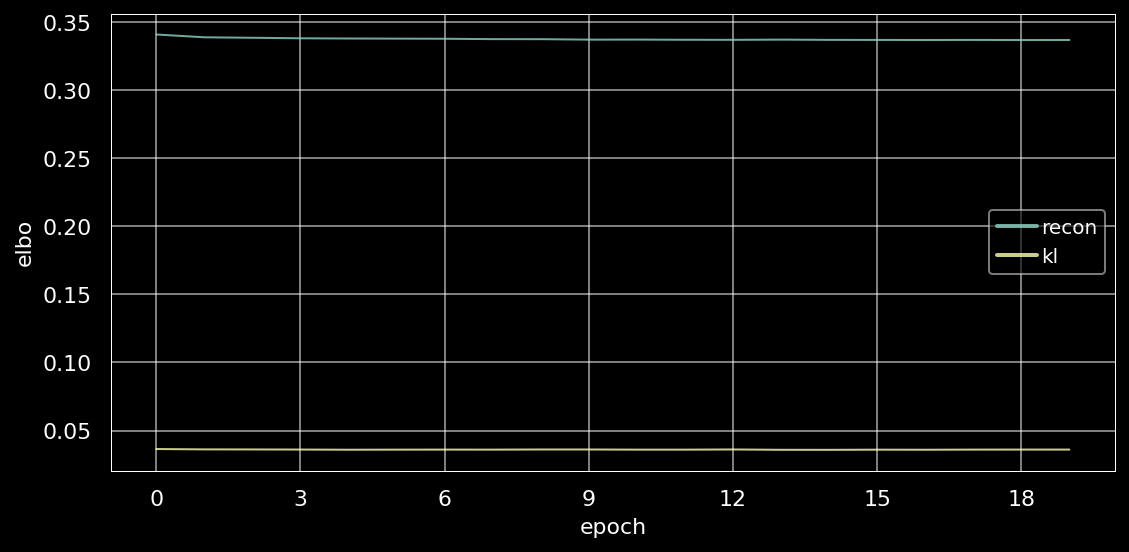

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(recon_losses, label="recon", alpha=0.8)
ax.plot(kl_losses, label="kl", alpha=0.8)
ax.set(xlabel="epoch",ylabel="elbo")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.tight_layout()
plt.show()

## Results

In [20]:
batch, _ = next(iter(test_loader))

orig = batch[:10]

recon, _, _ = vae(orig.to(device))
recon = recon.detach().cpu().permute(0,2,3,1).squeeze(3).numpy()

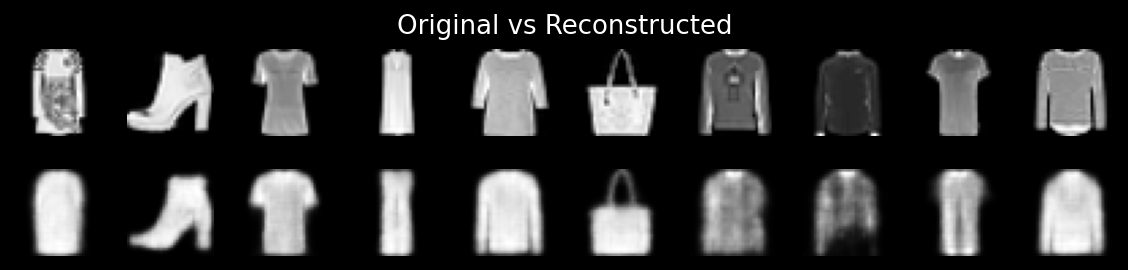

In [21]:
fig, ax = plt.subplots(2, 10, figsize=(8, 2))

for i in range(10):
    ax[0,i].imshow(orig[i].squeeze(0).numpy(), cmap='gray')
    ax[0,i].set_axis_off()

for i in range(10):
    ax[1,i].imshow(recon[i], cmap='gray')
    ax[1,i].set_axis_off()

fig.suptitle("Original vs Reconstructed")
plt.tight_layout()
plt.show()

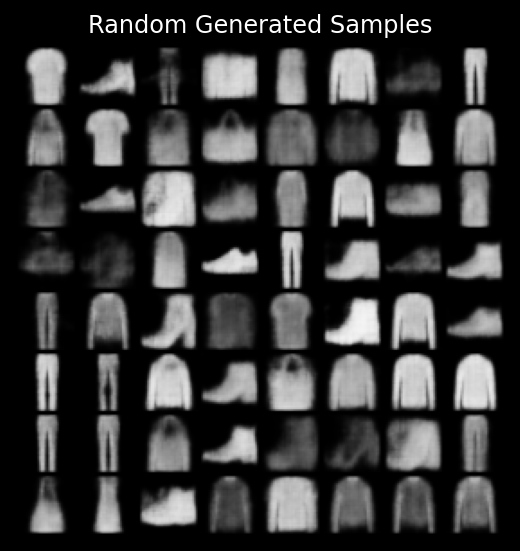

In [22]:
z = torch.randn(64, nz, device=device)
recon = vae.decoder(z).detach().cpu().view(-1,1,32,32)

fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(make_grid(recon,nrow=8).permute(1,2,0).numpy())
ax.set_axis_off()
ax.set_title("Random Generated Samples")

plt.tight_layout()
plt.show()

In [23]:
def slerp(p0, p1, t):
    omega = torch.arccos(torch.dot(p0 / torch.linalg.norm(p0), p1 / torch.linalg.norm(p1)))
    so = torch.sin(omega)
    return torch.sin((1.0 - t) * omega) / so * p0 + torch.sin(t * omega) / so * p1

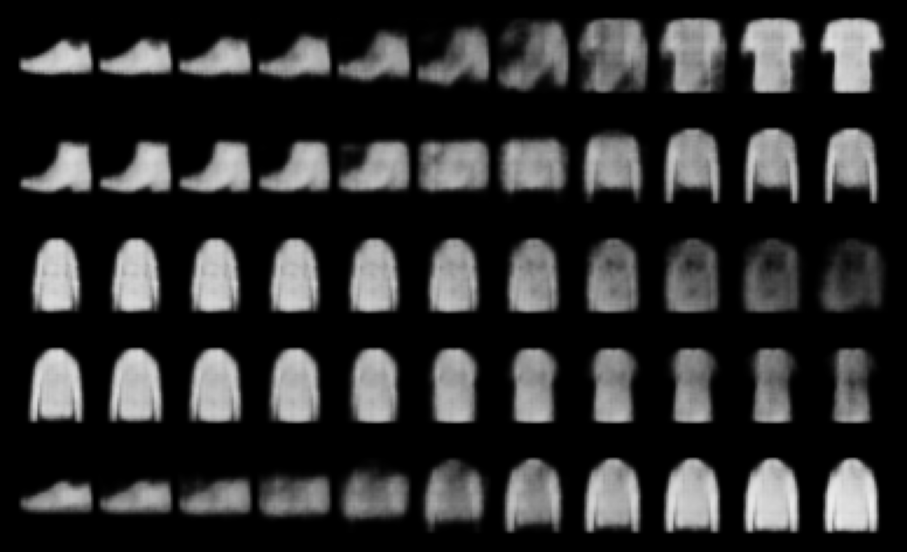

In [24]:
fig, ax = plt.subplots(5, 1, figsize=(8,4))

for i in range(5):
    orig = batch[np.random.randint(0, batch_size, 2)]
    mu, logvar = vae.encoder(orig.to(device))
    z1, z2 = vae.reparameterize(mu, logvar)
    z = torch.cat([slerp(z1, z2, t).unsqueeze(0) for t in np.arange(0,1.1,0.1)], dim=0)
    imgs = vae.decoder(z).detach().cpu()
    
    ax[i].imshow(make_grid(imgs,nrow=11).permute(1,2,0).squeeze(-1).numpy())
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()